<a href="https://colab.research.google.com/github/VavRe/nlp-ut/blob/main/CA3/Q1_Twitter_Sentiment_Analysis_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

--2023-05-13 16:48:08--  http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [following]
--2023-05-13 16:48:08--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip’

trainingandtestdata   0%[                    ]       0  --.-KB/s               


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, RNN
from keras.models import Sequential


In [4]:
columns = ["sentiment","id","datetime","query","user","tweet"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=columns)

In [5]:
df["sentiment"].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [6]:
df = df.loc[:,["sentiment","tweet"]]
df

,sentiment,tweet
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
from sklearn.model_selection import train_test_split

samples_fraction = 0.2
stratify_on = "sentiment"

_, dataset = train_test_split(df, stratify=df[stratify_on], 
                                 test_size=samples_fraction,
                                 random_state=76)

# Reset the index of the sampled DataFrame
dataset.reset_index(drop=True, inplace=True)


In [8]:
dataset["sentiment"].value_counts()

4    160000
0    160000
Name: sentiment, dtype: int64

In [9]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess_tweet(tweet, remove_stopwords=True, stem_words=True, handle_negation=True):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs, mentions, and hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#\w+", "", tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tweet_tokens = tweet.split()
        tweet = " ".join([word for word in tweet_tokens if word not in stop_words])
    
    # Stem words if specified
    if stem_words:
        stemmer = PorterStemmer()
        tweet_tokens = tweet.split()
        tweet = " ".join([stemmer.stem(word) for word in tweet_tokens])
        
    # Handle negation if specified
    if handle_negation:
        tweet_tokens = word_tokenize(tweet)
        negation_flag = False
        negated_tokens = []
        for i, token in enumerate(tweet_tokens):
            if token in ["not", "n't", "no"]:
                negation_flag = True
            elif negation_flag:
                negated_tokens.append("not_" + token)
                negation_flag = False
            else:
                negated_tokens.append(token)
        tweet = " ".join(negated_tokens)
    
    return tweet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
from tqdm import tqdm
tqdm.pandas(b)


dataset["tweet"] = tqdm(dataset["tweet"].apply(preprocess_tweet))

100%|██████████| 320000/320000 [00:00<00:00, 3264168.88it/s]


In [11]:
from keras.utils import to_categorical
X = dataset["tweet"]
y = dataset["sentiment"]

In [12]:
y = y.replace(4,1)
y = y.replace(4,1)

In [13]:
del df

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=76)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [15]:
vocab_size = 15000
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)

In [16]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [17]:
# Pad the sequences to a fixed length
max_length = 150
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)


In [20]:
!pip install kaggle ;
!mkdir ~/.kaggle/ ;
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/ ;
!chmod 600 ~/.kaggle/kaggle.json ;
!kaggle datasets download -d rtatman/glove-global-vectors-for-word-representation
!unzip  /content/glove-global-vectors-for-word-representation.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
glove-global-vectors-for-word-representation.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/glove-global-vectors-for-word-representation.zip
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.50d.txt        


In [21]:
# # Use one-hot vectors for one option
# X_train_onehot = tokenizer.sequences_to_matrix(X_train_seq, mode='binary')
# X_test_onehot = tokenizer.sequences_to_matrix(X_test_seq, mode='binary')

# Use GloVe embeddings for another option
glove_embeddings_index = {}
with open('glove.6B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove_embeddings_index[word] = coefs
embedding_dim = 200
glove_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [22]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout,SimpleRNN

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.05)


RNN_glove = Sequential()
RNN_glove.add(Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[glove_embedding_matrix], trainable=False))
RNN_glove.add(SimpleRNN(64))
RNN_glove.add(Dropout(0.2))
RNN_glove.add(Dense(2, activation='softmax'))
RNN_glove.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


hist = RNN_glove.fit(X_train_pad, y_train, epochs=100, batch_size=256, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
720/720 [==============================] - ETA: 0s - loss: 0.7423 - accuracy: 0.5498
Epoch 1: val_loss improved from inf to 0.71885, saving model to my_best_model.hdf5
720/720 [==============================] - 68s 85ms/step - loss: 0.7423 - accuracy: 0.5498 - val_loss: 0.7188 - val_accuracy: 0.5696
Epoch 2/100
720/720 [==============================] - ETA: 0s - loss: 0.7076 - accuracy: 0.5825
Epoch 2: val_loss improved from 0.71885 to 0.65534, saving model to my_best_model.hdf5
720/720 [==============================] - 61s 84ms/step - loss: 0.7076 - accuracy: 0.5825 - val_loss: 0.6553 - val_accuracy: 0.6030
Epoch 3/100
720/720 [==============================] - ETA: 0s - loss: 0.7186 - accuracy: 0.5677
Epoch 3: val_loss did not improve from 0.65534
720/720 [==============================] - 58s 81ms/step - loss: 0.7186 - accuracy: 0.5677 - val_loss: 0.9555 - val_accuracy: 0.5005
Epoch 4/100
720/720 [==============================] - ETA: 0s - loss: 0.7328 - accuracy: 0.5

In [23]:
y_pred = RNN_glove.predict(X_test_pad)

2000/2000 [==============================] - 28s 14ms/step


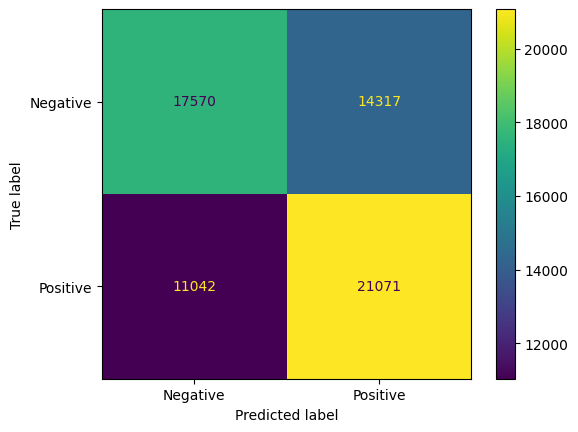

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()


In [25]:
from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))


              precision    recall  f1-score   support

    Negative       0.61      0.55      0.58     31887
    Positive       0.60      0.66      0.62     32113

    accuracy                           0.60     64000
   macro avg       0.60      0.60      0.60     64000
weighted avg       0.60      0.60      0.60     64000



In [26]:
tqdm.pandas()
dataset["tokenized"] = dataset["tweet"].progress_apply(word_tokenize)

100%|██████████| 320000/320000 [00:29<00:00, 10726.66it/s]


In [27]:
dataset["tokenized"]

0              [photo, monorail, cat, itâ, face, make, lol]
1                                                        []
2         [good, becom, millionair, within, next, week, ...
3                                  [drink, wonder, monster]
4                                   [ha, part, ye, love, u]
                                ...                        
319995    [way, dont, know, person, feel, free, say, hi,...
319996                                       [realli, deep]
319997                            [anoth, year, gone, good]
319998                                  [wouah, cool, work]
319999    [twitter, troquei, de, background, aqui, que, ...
Name: tokenized, Length: 320000, dtype: object

# Word2Vec

In [52]:
import gensim
from gensim.models import Word2Vec


w2v_model = Word2Vec(dataset["tokenized"].to_numpy(), vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [56]:
w2v_embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        break
    try: 
        embedding_vector = w2v_model.wv.get_vector(word)
    except KeyError:
        print(f"the word {word} is not available")
    if embedding_vector is not None:
        w2v_embedding_matrix[i] = embedding_vector


the word not is not available
the word o is not available
the word t is not available
the word m is not available


array([ 1.00721279e-02, -3.41042206e-02, -5.86261414e-03, -2.70256470e-03,
        4.09544557e-02, -5.21603897e-02, -1.12973833e-02,  3.14934067e-02,
       -3.02720703e-02,  1.09828636e-02, -3.14188190e-02, -4.48775366e-02,
       -1.17258253e-02,  1.09400302e-02,  5.97905880e-03, -2.44387332e-02,
       -2.14196872e-02, -2.95038987e-02,  3.46899219e-02, -3.04313879e-02,
        3.40622291e-02, -1.51141584e-02, -1.87488161e-02,  2.24211738e-02,
       -8.56762286e-03, -5.16238110e-03,  2.94313226e-02, -1.02867605e-02,
       -5.47003262e-02,  8.18889309e-03,  1.89664308e-02,  2.42090095e-02,
       -1.46355564e-02, -4.56685610e-02,  2.70694662e-02,  3.97607088e-02,
        2.89372820e-02, -4.27386686e-02, -3.30749191e-02, -5.97777814e-02,
       -4.88689682e-03, -6.23862958e-03, -3.78334560e-02,  4.85524116e-03,
        5.07638566e-02, -9.63994360e-04, -1.13259153e-02,  8.74983525e-05,
        2.31539458e-03,  2.66847070e-02,  3.31290402e-02, -2.10547578e-02,
       -8.19257647e-03,  